In [1]:
import tensorflow as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import tensorflow_hub as hub

In [2]:
# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

In [3]:
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [4]:
# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.2.0
The following GPU devices are available: 


In [5]:
#module = hub.load('https://tfhub.dev/google/imagenet/inception_v3/classification/1')

In [10]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
             display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

Image downloaded to C:\Users\NIGHTR~1\AppData\Local\Temp\tmpqns3fytx.jpg.


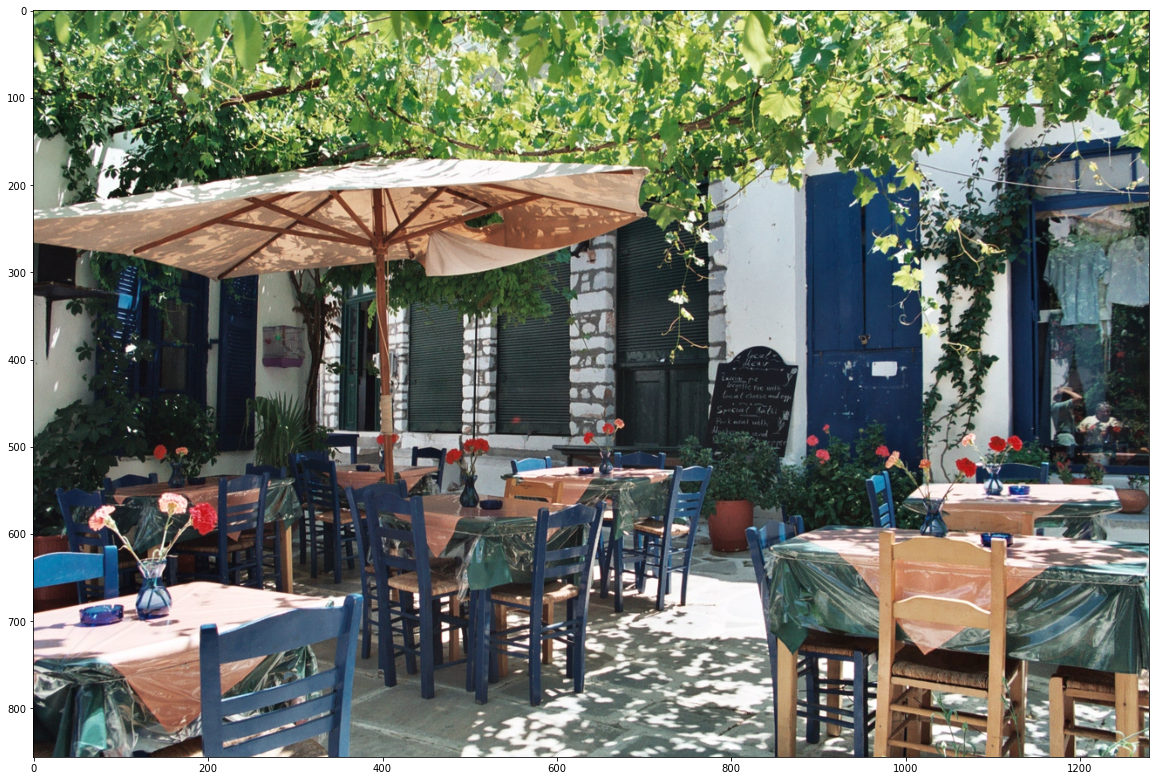

In [11]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [13]:
module_handle ="https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  
#@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [15]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

Found 100 objects.
Inference time:  87.37428665161133
Font not found, using default font.


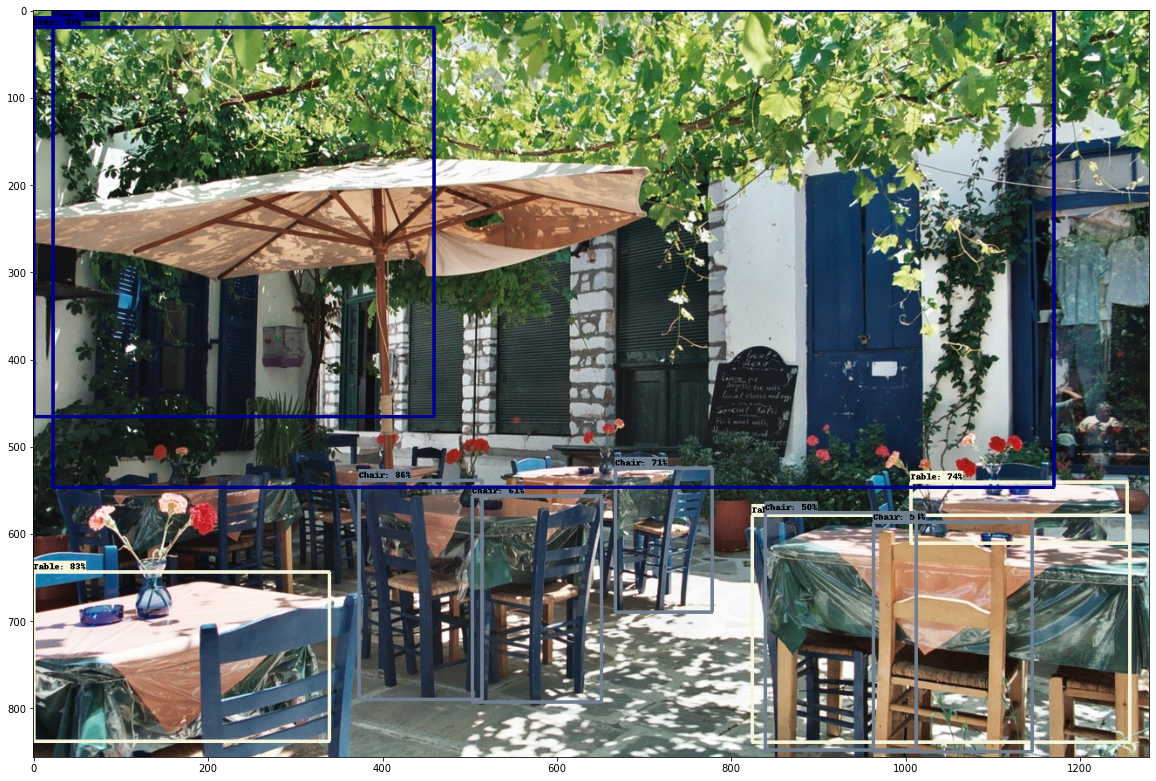

In [16]:
run_detector(detector,downloaded_image_path)

In [19]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

In [20]:
def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

Image downloaded to C:\Users\NIGHTR~1\AppData\Local\Temp\tmpkvp1dr22.jpg.
Found 100 objects.
Inference time:  21.7896990776062
Font not found, using default font.
Inference time: 22.319281101226807


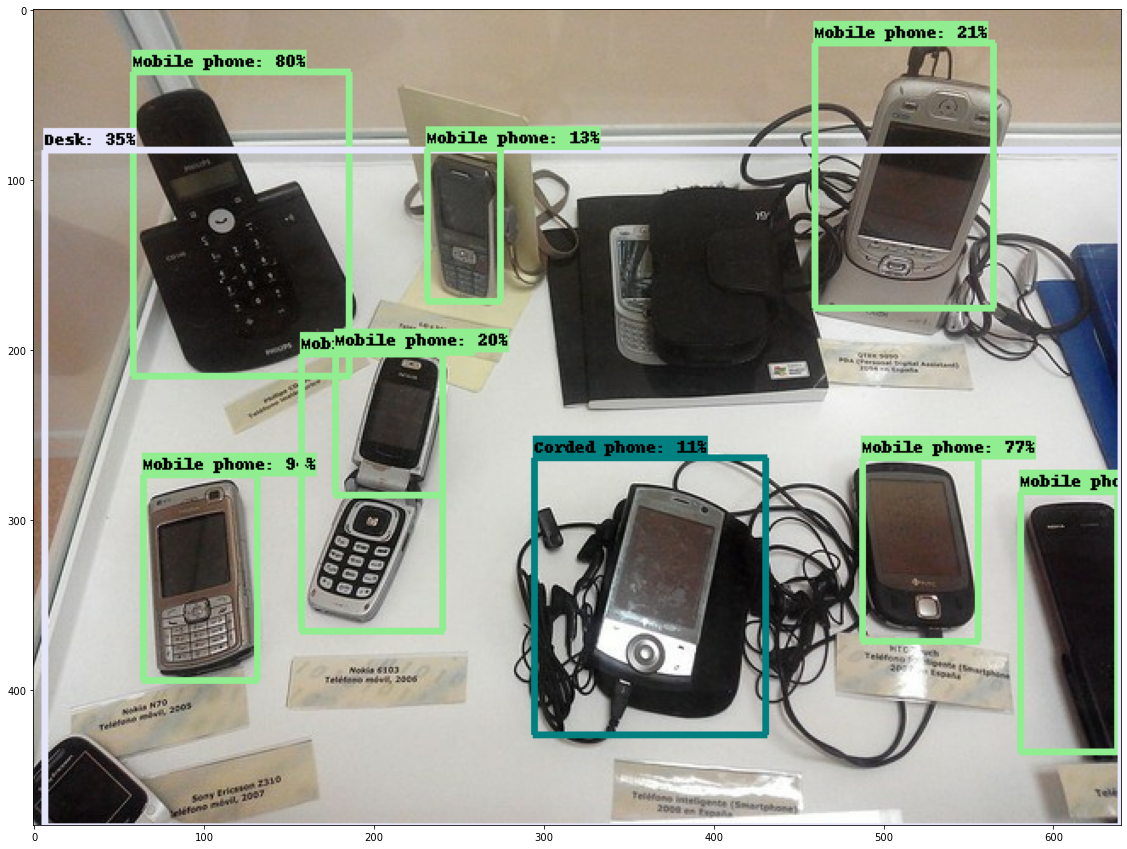

In [22]:
detect_img(image_urls[1])

Found 100 objects.
Inference time:  28.2673819065094
Font not found, using default font.


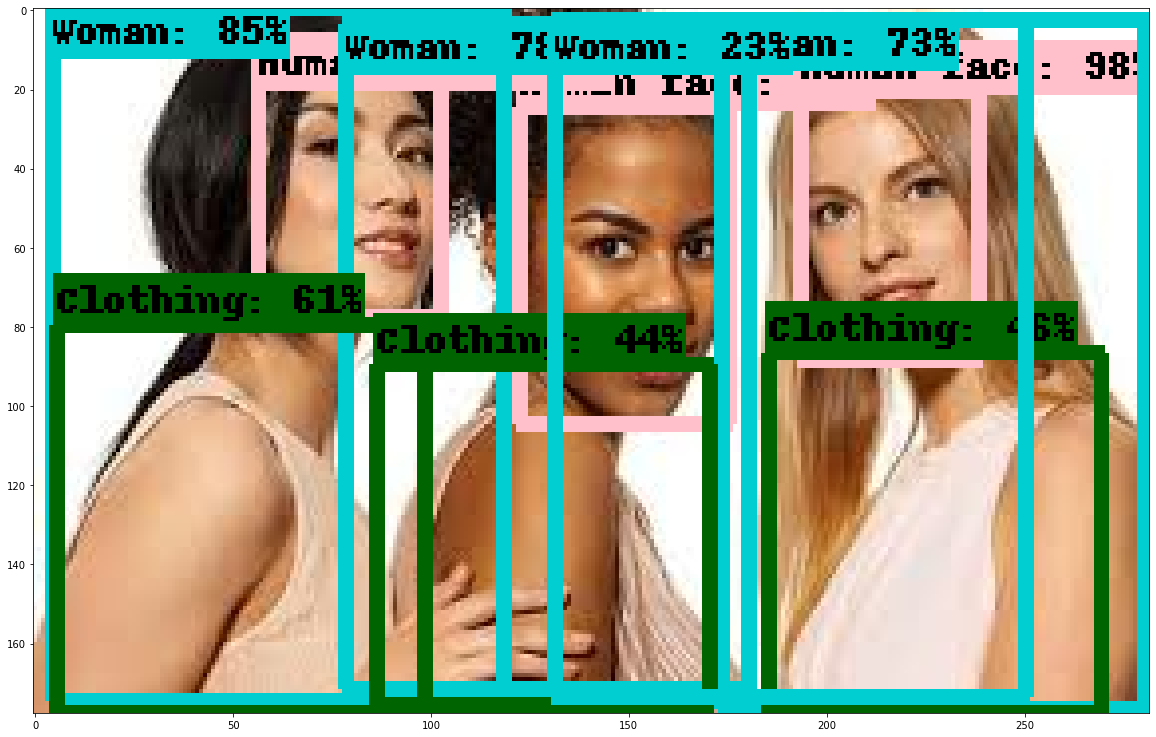

In [11]:
run_detector(detector,"C:\Python\woman.jpg")

In [13]:
img = load_img("C:\Python\me.jpg")

converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
start_time = time.time()
result = detector(converted_img)
end_time = time.time()

result = {key:value.numpy() for key,value in result.items()}

print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

Found 100 objects.
Inference time:  20.189953327178955


In [14]:
result["detection_class_entities"]

array([b'Human face', b'Man', b'Clothing', b'Lipstick', b'Human mouth',
       b'Human eye', b'Human nose', b'Shirt', b'Human eye', b'Boy',
       b'Human hair', b'Human head', b'Human ear', b'Person', b'Clothing',
       b'Human ear', b'Woman', b'Human ear', b'Human hair', b'Human hair',
       b'Human eye', b'Human eye', b'Human body', b'Person', b'Clothing',
       b'Mammal', b'Human hair', b'Shirt', b'Human head', b'Man',
       b'Human ear', b'Human hair', b'Human arm', b'Clothing', b'Girl',
       b'Human beard', b'Human body', b'Sports uniform', b'Human ear',
       b'Man', b'Human beard', b'Suit', b'Human hair', b'Human hair',
       b'Man', b'Man', b'Human arm', b'Bust', b'Human ear', b'Clothing',
       b'Human head', b'Human arm', b'Human hair', b'Human ear',
       b'Human arm', b'Human arm', b'Human hair', b'Human arm',
       b'Human body', b'Human beard', b'Fashion accessory', b'Suit',
       b'Human arm', b'Fashion accessory', b'Human arm', b'Human hair',
       b'Human

In [101]:
def face_position(result):
    face_positoin_address = []
    for i in range(len(result["detection_class_entities"].tolist())):
        if result["detection_class_entities"].tolist()[i] == b'Human face':
            face_positoin_address.append([i])
    return face_positoin_address

In [61]:
face_positoin(result)

[[0]]

In [100]:
def head_position(result):
    head_positoin_address = []
    for i in range(len(result["detection_class_entities"].tolist())):
        if result["detection_class_entities"].tolist()[i] == b'Human head':
            head_positoin_address.append([i])
    return head_positoin_address

In [84]:
head_positoin(result)

[[23], [27], [61], [72], [76], [92]]

In [99]:
def eye_position(result): 
    eye_positoin_address = []
    for i in range(len(result["detection_class_entities"].tolist())):
        if result["detection_class_entities"].tolist()[i] == b'Human eye':
            eye_positoin_address.append([i])
    return eye_positoin_address

In [67]:
eye_positoin(result)

[[36], [58]]

In [92]:
def nose_position(result):
    nose_positoin_address = []
    for i in range(len(result["detection_class_entities"].tolist())):
        if result["detection_class_entities"].tolist()[i] == b'Human nose':
            nose_positoin_address.append([i])
    return nose_positoin_address

In [93]:
nose_position(result)

[[20], [35], [47], [49], [93]]

In [98]:
def mouth_position(result):
    mouth_positoin_address = []
    for i in range(len(result["detection_class_entities"].tolist())):
        if result["detection_class_entities"].tolist()[i] == b'Human mouth':
            mouth_positoin_address.append([i])
    return mouth_positoin_address

In [72]:
mouth_positoin(result)

[[23]]

In [25]:
result["detection_boxes"][5]

array([0.36285615, 0.27347955, 0.4245725 , 0.427396  ], dtype=float32)

In [26]:
result["detection_boxes"][8]

array([0.36389065, 0.56483364, 0.42618212, 0.7258522 ], dtype=float32)

In [27]:
result["detection_boxes"][20]

array([0.3502323 , 0.54330593, 0.43377447, 0.76077634], dtype=float32)

In [28]:
result["detection_boxes"][21]

array([0.34689558, 0.2560894 , 0.43202195, 0.4434951 ], dtype=float32)

In [29]:
import cv2 
import numpy as np
import dlib
import numpy as np
import imutils
from imutils import face_utils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import matplotlib.pyplot as plt
import csv
import argparse
import math

In [40]:
def get_images_from_video(video_name, time_F):
    video_images = []
    vc = cv2.VideoCapture(video_name)
    c = 1
    
    if vc.isOpened(): #判斷是否開啟影片
        rval, video_frame = vc.read()
    else:
        rval = False

    while rval:   #擷取視頻至結束
        rval, video_frame = vc.read()
        
        if(c % time_F == 0): #每隔幾幀進行擷取
            video_images.append(video_frame)     
        c = c + 1
    vc.release()
    
    return video_images

In [73]:
def face_area(pic):
    gray_img = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY) 
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")  
  
    faces = face_cascade.detectMultiScale(gray_img)  
    #for x,y,w,h in faces:  
    #    img = cv2.rectangle(pic, (x,y), (x+w,y+h),(0,255,0),3)
    if len(faces)>0:
        [x,y,w,h]=faces[np.argmax(faces[:,2])]
    else:
        [x,y,w,h]=np.array([0,0,0,0])
    return x,y,w,h

In [74]:
def crop(pic,x,y,w,h):
    [x,y,w,h]=face_area(pic)
    if w>100:
        crop_img=pic[y:y+h,x:x+w]
    else:
        crop_img=pic[y:y+100,x:x+100]
    return crop_img

In [46]:
time_F =10 #time_F越小，取樣張數越多
video_name = 'Allen_3_1.mp4' #影片名稱
video_images = get_images_from_video(video_name, time_F) #讀取影片並轉成圖片

In [109]:
pic=video_images[3]
[x,y,w,h]=face_area(pic)
img=crop(pic,x,y,w,h)
img=video_images[3]
converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
start_time = time.time()
result = detector(converted_img)
end_time = time.time()

result = {key:value.numpy() for key,value in result.items()}

print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

image_with_boxes = draw_boxes(
      img, result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

display_image(image_with_boxes)

Found 100 objects.
Inference time:  19.612595319747925
Font not found, using default font.


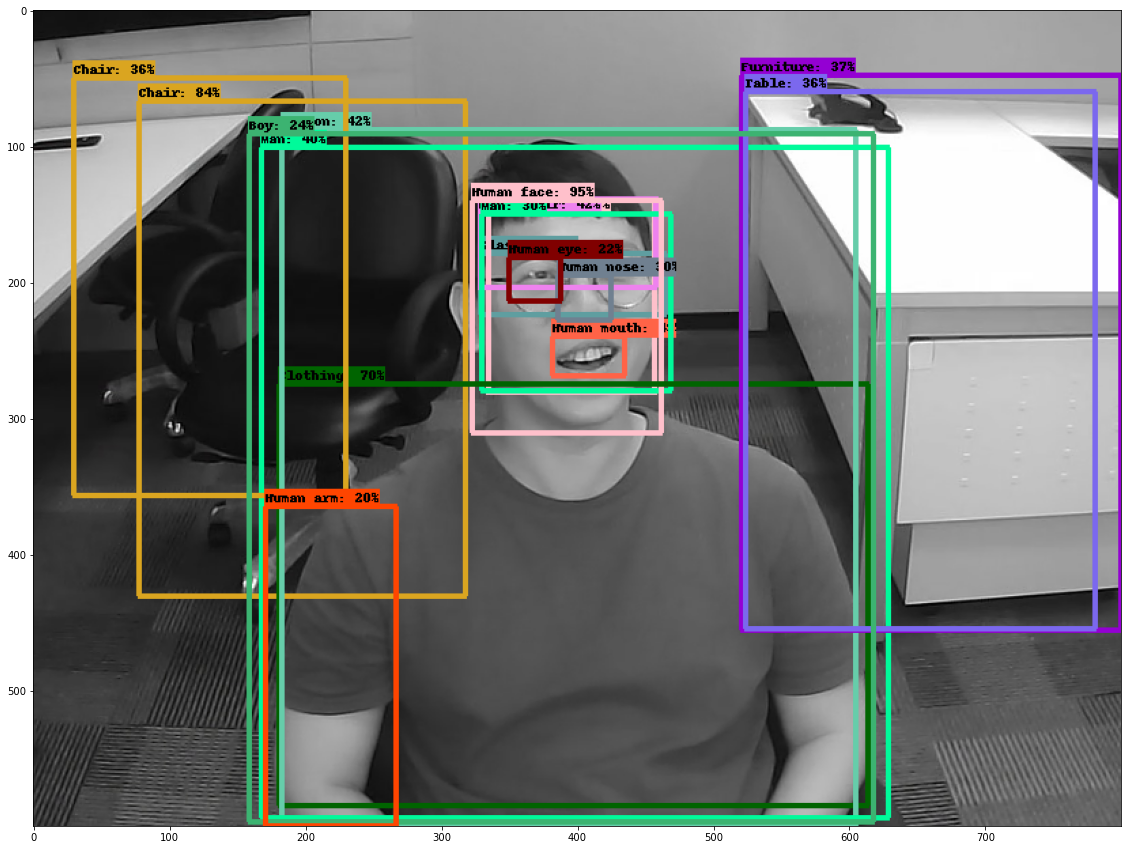

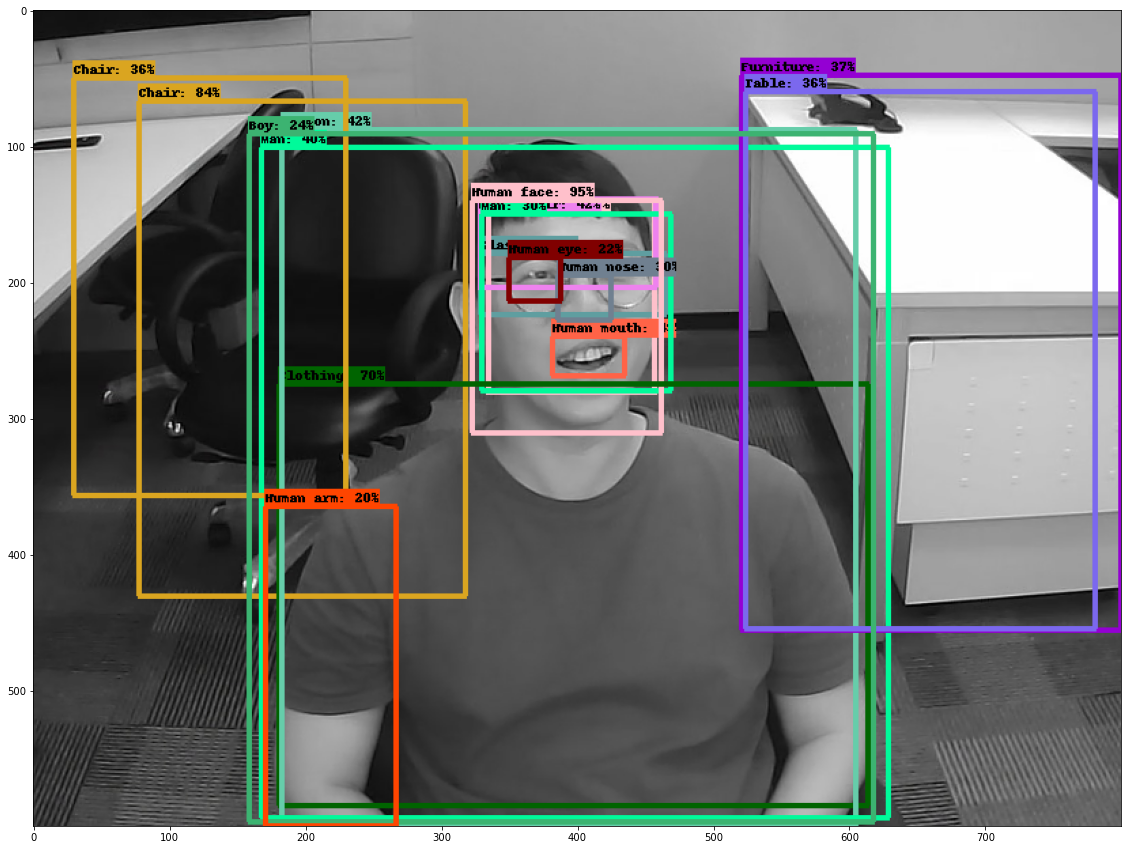

In [110]:
display_image(image_with_boxes)

In [102]:
face_position(result)

[[2], [4], [19], [28], [34], [45], [66], [87]]

In [103]:
head_position(result)

[[23], [27], [61], [72], [76], [92]]

In [104]:
eye_position(result)

[[1], [7], [10], [13], [17], [37], [42], [52], [59], [62], [96], [97]]

In [105]:
nose_position(result)

[[20], [35], [47], [49], [93]]

In [106]:
mouth_position(result)

[[36], [79]]

In [50]:
#img = tf.image.decode_jpeg(video_images[0], channels=3)

In [51]:
converted_img  = tf.image.convert_image_dtype(video_images[2], tf.float32)[tf.newaxis, ...]
start_time = time.time()
result = detector(converted_img)
end_time = time.time()

result = {key:value.numpy() for key,value in result.items()}

print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

Found 100 objects.
Inference time:  21.281132459640503


In [52]:
score=[]
for j in range(len(result["detection_scores"])):
    if result["detection_scores"][j]>0.9:
        score.append(j)

In [53]:
score

[0, 1]

In [54]:
result["detection_scores"]

array([0.9569161 , 0.91283166, 0.8881507 , 0.78558004, 0.44115713,
       0.38479304, 0.35089207, 0.320972  , 0.2900433 , 0.261846  ,
       0.22129142, 0.20488204, 0.19800629, 0.1609375 , 0.14819455,
       0.1470324 , 0.14393333, 0.13868345, 0.13676941, 0.13598809,
       0.13511962, 0.12107366, 0.10938431, 0.06306161, 0.06299201,
       0.06171563, 0.05738378, 0.05515396, 0.05389236, 0.05333369,
       0.04276357, 0.04182633, 0.04028493, 0.03857445, 0.03815299,
       0.03614304, 0.03598488, 0.03554516, 0.03465806, 0.03310804,
       0.0306847 , 0.02970127, 0.02942372, 0.02863225, 0.02802855,
       0.02498683, 0.02464992, 0.02333459, 0.02204911, 0.02167714,
       0.02115219, 0.02048931, 0.02005357, 0.01929896, 0.01649621,
       0.0155025 , 0.01446343, 0.01389948, 0.01372669, 0.01344273,
       0.01282633, 0.01253477, 0.01195553, 0.01133158, 0.01086178,
       0.01073369, 0.01066071, 0.01009462, 0.01000465, 0.00975275,
       0.00928699, 0.00917319, 0.00887971, 0.00874054, 0.00799

In [56]:
result["detection_class_entities"]

array([b'Human face', b'Glasses', b'Chair', b'Clothing', b'Woman',
       b'Chair', b'Furniture', b'Boy', b'Person', b'Table', b'Man',
       b'Desk', b'Human arm', b'Window', b'Office building', b'Table',
       b'Human head', b'Drawer', b'Human hair', b'Human arm', b'Girl',
       b'Table', b'Furniture', b'Human mouth', b'Chest of drawers',
       b'Cabinetry', b'Furniture', b'Filing cabinet', b'Cabinetry',
       b'Nightstand', b'Box', b'Chair', b'Table', b'Chair',
       b'Chest of drawers', b'Desk', b'Human eye', b'Medical equipment',
       b'Mammal', b'Human ear', b'Human arm', b'Human arm',
       b'Filing cabinet', b'Human body', b'Shelf', b'Furniture',
       b'Office supplies', b'Drawer', b'Furniture', b'Chair',
       b'Furniture', b'House', b'Nightstand', b'Shirt',
       b'Medical equipment', b'Footwear', b'Cupboard', b'Shelf',
       b'Human eye', b'Medical equipment', b'Kitchen appliance',
       b'Human arm', b'Countertop', b'Office supplies',
       b'Office building'

In [211]:
cv2.imshow("me",video_images[2].copy())

Font not found, using default font.


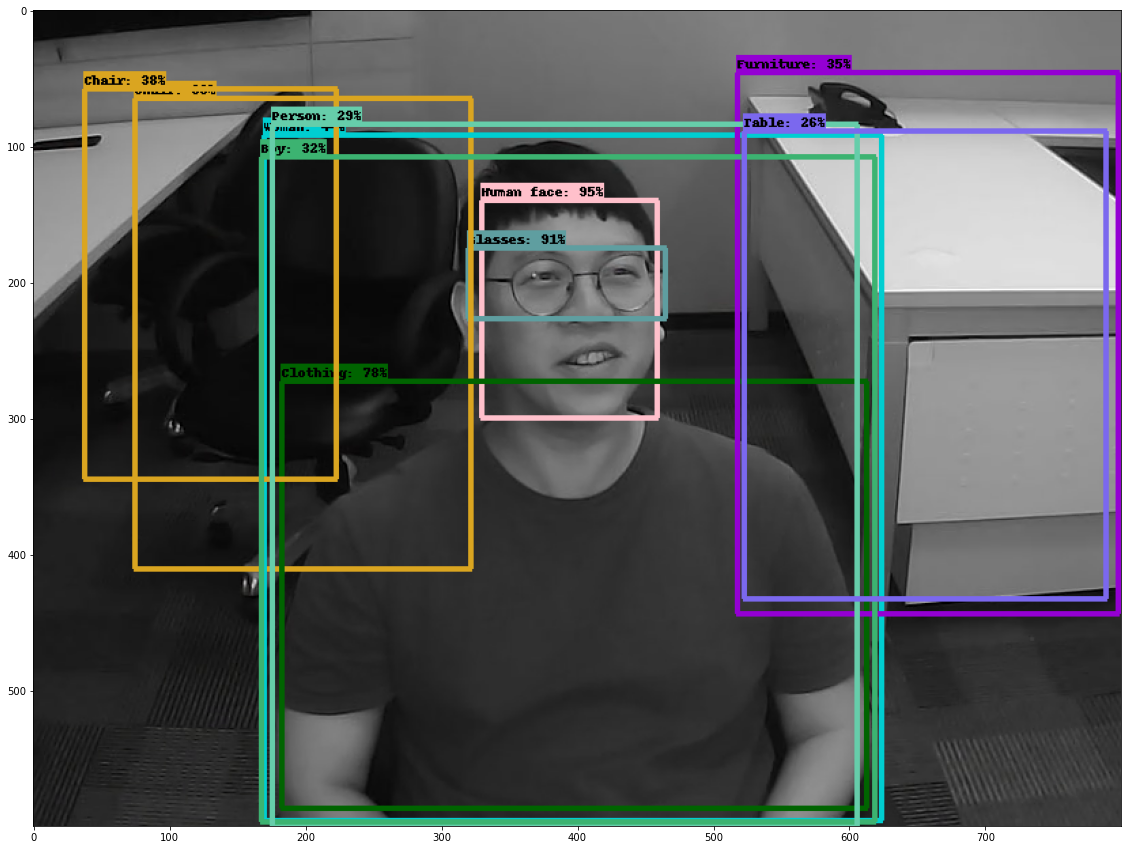

In [57]:
image_with_boxes = draw_boxes(
      video_images[0], result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

display_image(image_with_boxes)

Font not found, using default font.


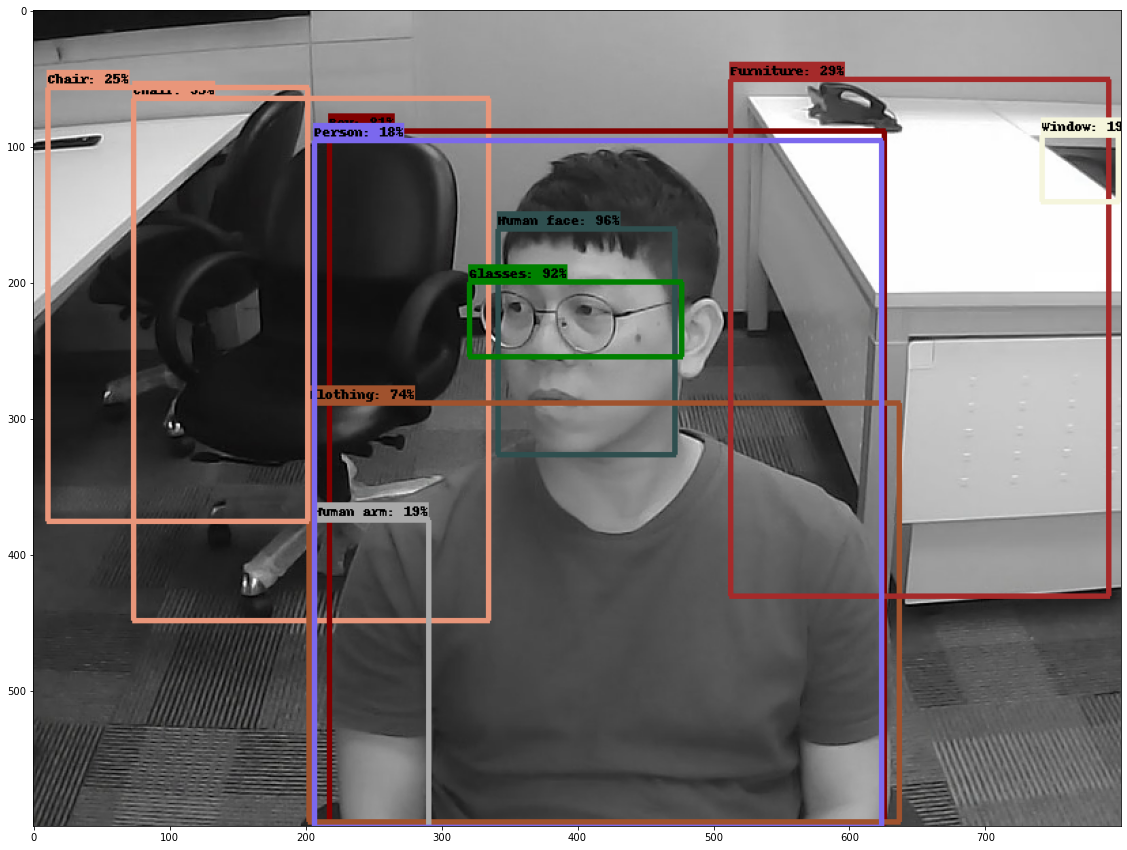

In [202]:
image_with_boxes = draw_boxes(
      video_images[2], result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

display_image(image_with_boxes)